# Mathematical Language Text Understanding with Pointer Network

In this tutorial, we will be using a pointer network to predict the position of a definiton of a mathematical variable given a variable name and the context in which it is defined.

## The Pointer Network

Instead of finding the conditional probability over the entire input vocabulary like other seq2seq models, the pointer network finds the probability over positional tokens of the input sequence. In other words, the pointer network learns the position of optimal word rather then the optimal word itself. It achives this by employing a simple modification of the Bahdanau attention when it decodes. This framework is ideal for definition extraction because the set of possible answers is drastically reduced while still containing the correct answer.

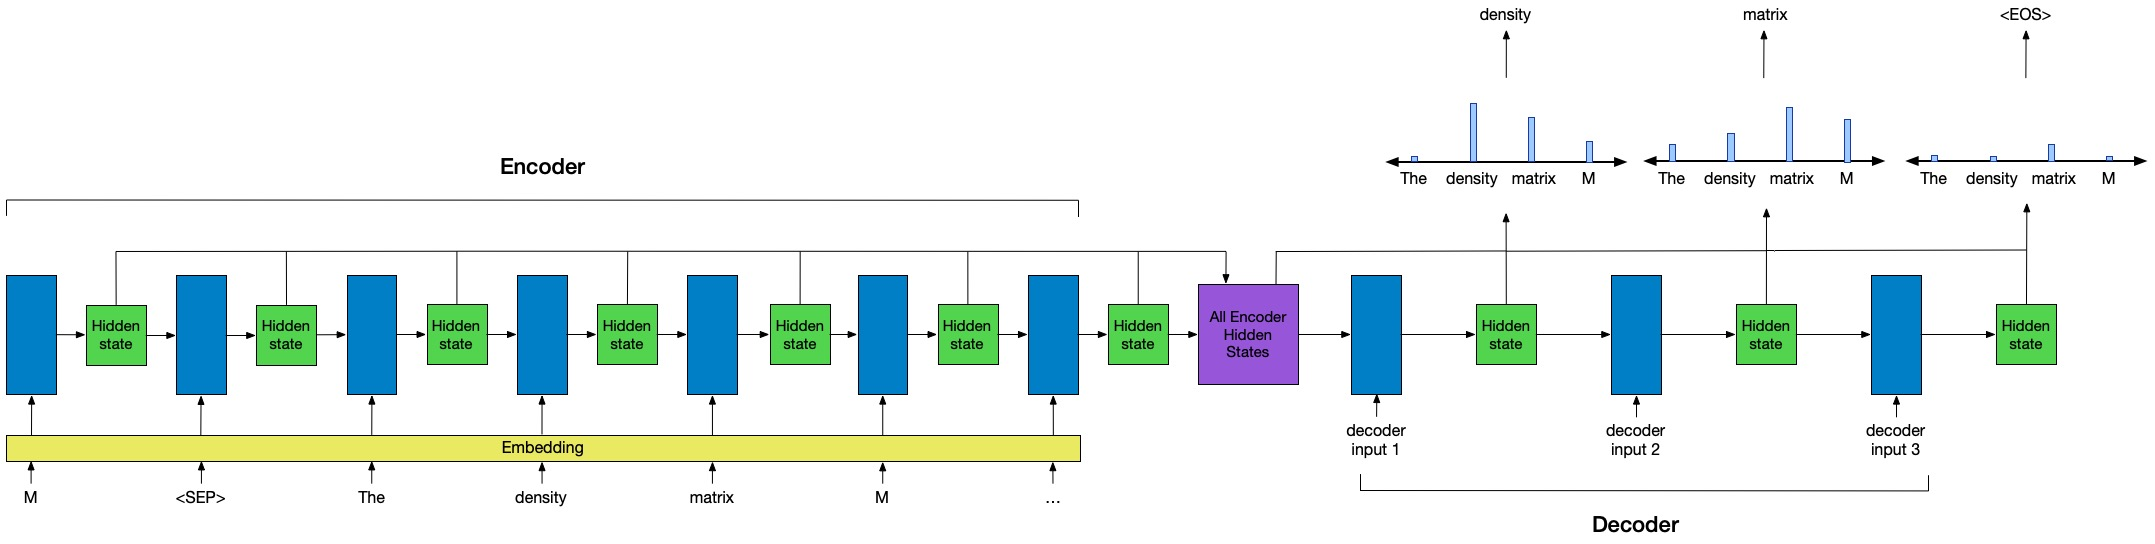

The model in this tutorial is based of the original pointer network paper (https://arxiv.org/pdf/1506.03134.pdf). Let's take a better look at how this model functions. First, just like in every seq2seq-like model, the encoder calculates the hidden state of each token in the input sentence. Then, during decoding, we calculate the most probable token for each possible token in the definition. The probability is calculated using attention between the decoder hidden state and the encoder hidden states, which is calculated as:

\begin{align}
u^{i}_{j} = v^{T}tanh(W_{1}e_{j} + W_{2}d_{i})
\end{align}
\begin{align}
p_{\theta}(y|T; \theta) = softmax(u^{i})
\end{align}

where $e_{j}$ is the encoder state at the $j$-th input word, $d_{i}$ is the decoder state at the $i$-th answer word, and $v$, $W_{1}$, $W_{2}$ are learnable parameters.

## Let's get started!
To start, let's define a Pytorch Dataset. This is a data object will take our data and prepare it to be fed into a model. This entails cleaning the data, tokenizing it, and partitioning it into batchs. I highly recommend the use of the pytorch dataset object in any pytorch project you may do because of its compatability with the pytorch dataloader. The dataloader will batch and randomize your data for you, making it easy to train your model.

## The Data and How We Process It
The data used in this tutorial is sourced from mathematical and physics papers from arXiv and manually cleaned. For each entry in the dataset, we are given a variable name, the context in which it is defined, and an definition of the variable. The model should process the variable name and the context and should be able to predict the positional tokens of output. However, encoder-decoded models are not generally equipt to handle two input variables. Thus, inspired by BERT models, we opted to combined the two inputs into one with a \<SEP\> token. This can be seen the picture above. 
    
Our dataset has variable length definitions, so we need a way to adding an \<EOS\> and \<PAD\> token to output tensors. To do this, we add an \<EOS\> and \<PAD\> token to the end of each context so the output can use their positions to generate those tokens. We also pad each output to the maximum output length for ease of training and testing. 

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import math

In [ ]:
class PointerDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        # The tokenized inputs and outputs
        self.texts = []
        self.outputs = []
        
        # Maps each index to a unique word and vice versa
        self.word2index = {}
        self.index2word = {0: "PAD", 1: "EOS", 2: "SEP"}
        self.pad = 0
        self.eos = 1
        self.sep = 2
        
        self.size = len(self.index2word)
        self.context_max_len = 0
        self.def_max_len = 0
        
        # Process data
        self.prep_data()

    def get_idx(self, context, definition):
        """This function finds positional token of 'definition' in 'context'. 

        Args:
          context: the context in which the variable is defined
          definition: the definition of the variable

        Returns:
          The position of 'definition' in 'context'
        """
        context_split = context.split(" ")
        if definition in context_split:
            # base case, return the idx of the definition in the context
            idx = context_split.index(definition)
        else:
            # This should cover an edge case where the correct definition is the singular version
            # of the definition of the text. It finds the idx of the most similar word to the definition. 
            max_common = 0
            most_likely_idx = 0
            for i in range(len(context_split)):
                word_dist = len(set(definition).intersection(set(context_split[i])))
                if max_common < word_dist:
                    max_common = word_dist
                    most_likely_idx = i
                        
            idx = most_likely_idx
        
        return idx

    def add_text(self, text):
        """Assigns a unique index to each word in a sentence

        Args:
          text: A sentence
        """
        for word in text.split(' '):
            if word not in self.word2index:
                self.word2index[word] = self.size
                self.index2word[self.size] = word
                self.size += 1

    def clean_text(self, text):
        """Strips text of any punctuation, converts to lower case, and gets rid of any 
        unnecessary white space

        Args:
          text: the uncleaned sentence.

        Returns:
          The cleaned sentence.
        """
        text = text.replace('"', '').lower().strip()
        text = text.replace(",", "").replace(".", "").replace("!", "").replace("?", "").replace("(", "").replace(")", "").replace(":", "").replace("|", " ").replace("  ", " ").strip().replace(";", "")
        text = text.split(" ")
        text = ' '.join(text)
        return text

    def prep_data(self):
        max_len = 0
        def_max_len = 0
        for index, row in self.df.iterrows():
            var = self.clean_text(row["var"])
            context = self.clean_text(row["context"])
            definition = self.clean_text(row["def"])

            self.add_text(context)

            # Tokenize input and outputs texts
            # For the seq2seq models, we use a 'bert-like' input text that combines the two input sequences with a <SEP> token
            input_text = [self.word2index[var]] + [self.sep] + [self.word2index[c] for c in context.split(" ")] + [self.eos] + [self.pad]
            
            # We add 2 as we need to account for the variable name token and the <SEP> token
            output_text = [self.get_idx(context, word) + 2 for word in definition.split(" ")]
            self.texts.append(input_text)
            self.outputs.append(output_text)

            if len(input_text) > max_len:
                max_len = len(input_text)

            if len(definition.split(' ')) > def_max_len:
                def_max_len = len(output_text)

        # Set the maximum text and definiton length
        # This is important when defining the models
        self.context_max_len = max_len
        self.def_max_len = def_max_len

    def collate_fn(self, batch):
        """This function is used by the dataloader to create batchs.
        It seperates the inputs and the outputs and then pads them.

        Args:
          batch: A list of data entries of size batch_size.

        Returns:
          The padded inputs and outputs.
        """
        inputs = []
        outputs = []
        
        for b in batch:
            inputs.append(torch.LongTensor(b[0]))
            
            # all outputs are padded to the maximum output length (might tweak this later)
            output_pad_length = self.def_max_len - len(b[1]) - 1
            
            # each context text has an EOS token and a PAD token at the end
            # The pointer network points to these tokens when generating an EOS or a PAD token
            output_eos = len(b[0]) - 2
            output_pad = len(b[0]) - 1
            outputs.append(torch.LongTensor(b[1] + [output_eos] + ([output_pad] * output_pad_length)))

        return (pad_sequence(inputs), pad_sequence(outputs))

    def __len__(self):
        """This is a required function.
        It returns the size of the dataset.
        
        Returns:
          The size of the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """This is a required function.
        It returns the data entry at index at idx.
        
        Args:
          idx: An index.
          
        Returns:
          The data entry at index idx.
        """
        return (self.texts[idx], self.outputs[idx])

## Implementing the Pointer Network

In [ ]:
class PointerNetwork(nn.Module):
    """This implementation was inspired by: https://github.com/jojonki/Pointer-Networks"""
    def __init__(self, learning_rate, context_max_len, def_max_len, size, hidden_size, optimizer, batch_size):
        super(PointerNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = size
        self.def_max_len = def_max_len
        self.context_max_len = context_max_len
        self.batch_size = batch_size

        self.emb = nn.Embedding(self.input_size, hidden_size)
        self.encoder = nn.LSTM(hidden_size, hidden_size)
        self.decoder = nn.LSTM(hidden_size, hidden_size)

        self.W1 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W2 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.v = nn.Linear(hidden_size, 1, bias=False)

        if optimizer == "sgd":
            self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        else:
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, input):
        input = self.emb(input)

        # Encoding
        encoder_outputs, encoder_hidden = self.encoder(input) # encoder_state: (input_size, batch_size, hidden_size)

        # Decoding states initialization
        decoder_input = torch.zeros(1, self.batch_size, self.hidden_size)
        decoder_hidden = torch.zeros([1, self.batch_size, self.hidden_size])
        decoder_cell_states = encoder_hidden[0]  # (batch_size, hidden_size)
        
        probs = []
        # Decoding
        for i in range(self.def_max_len):
            _, (decoder_hidden, decoder_cell_states) = self.decoder(decoder_input, (decoder_hidden, decoder_cell_states))
            
            # Compute attention
            attn = torch.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden)) # (input_size, batch_size, hidden_size)
            attn = self.v(attn).squeeze() # (input_size, batch_size)
            out = F.log_softmax(attn.permute((1, 0)), -1) # (batch_size, input_size)
            probs.append(out)

        probs = torch.stack(probs, dim=1) # (batch_size, def_max_len, input_size)
        return probs

    def train(self, dataloader, epochs):
        for e in range(epochs):
            avg_loss = 0
            # input_tensor: (input_length, batch_size), target_tensor: (target_length, batch_size)
            for input_tensor, target_tensor in dataloader:
                probs = self.forward(input_tensor)
                outputs = probs.permute((1, 0, 2)) # (def_max_len, batch_size, context_max_len)
                
                loss = 0
                for i in range(self.def_max_len):
                    loss += F.nll_loss(outputs[i], target_tensor[i])
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                avg_loss += loss.item()

            if e % 2 == 0:
                print("epoch", e, np.round(avg_loss / len(dataloader), 3))

    def evaluate(self, dataloader):
        correct = 0
        precision = 0
        recall = 0

        # input_tensor: (input_length, batch_size), target_tensor: (target_length, batch_size)
        for input_tensor, target_tensor in dataloader:
            with torch.no_grad():
                probs = self.forward(input_tensor)
                outputs = torch.argmax(probs, -1)
                
                # permute so every tensor is one output
                target_tensor = target_tensor.permute((1, 0)).type(torch.LongTensor)

                # Count the number of completely correct outputs
                correct += sum([1 for i, j in zip(outputs, target_tensor) if torch.equal(i, j)])             

                precision += sum([len(np.intersect1d(i, j)) / len(i) for i, j in zip(outputs, target_tensor)])
                recall += sum([len(np.intersect1d(i, j)) / len(j) for i, j in zip(outputs, target_tensor)])

        data_size = (dataloader.batch_size * len(dataloader))
        
        # Get average precision and recall score
        precision /= data_size
        recall /= data_size

        F1_score = (2 * precision * recall) / (precision + recall)
        return np.round(correct / data_size, 3), np.round(F1_score, 3)

## Putting It All Together
Now that we have all the important parts implemented, let's train and evaluate the model!

In [ ]:
data = pd.read_csv("data.csv")

# Randomize the dataframe
data = data.sample(frac=1).reset_index(drop=True)

dataset = PointerDataset(data)

# we use a 80/20 split to partition the data into training and testing data
i = math.floor(0.8 * len(data))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [i, len(data) - i])

In [ ]:
# Play around with these variables!
hid_size = 516 # hidden state size
lr = 0.1
epochs = 10
optimizer = 'sgd' # can also be 'adam'
batch_size = 32

# Dataloaders are awesome: they randomize and batch your data for you!
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=dataset.collate_fn, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=dataset.collate_fn, drop_last=True)

In [ ]:
model = PointerNetwork(lr, dataset.context_max_len, dataset.def_max_len, dataset.size, hid_size, optimizer, batch_size)
print("TRAINING MODEL")
model.train(train_dataloader, epochs)

# Evaluate model
training_total_correct, training_F1_score = model.evaluate(train_dataloader)
print("PERFORMANCE ON TRAINING DATA", "completely correct:", training_total_correct, "F1 score:", training_F1_score)

testing_total_correct, testing_F1_score = model.evaluate(test_dataloader)
print("PERFORMANCE ON TESTING DATA", "completely correct:", testing_total_correct, "F1 score:", testing_F1_score)